# Running models individually for each house

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import time
import xgboost as xgb
from scripts.function_utils import last_energy_points, build_predict_show, total_averaged_metrics_individual, show_graphic_per_timestep

In [2]:
data = pd.read_excel("~/datasets/Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


### Normalize data

In [3]:
values = df.values
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(df_scaled)
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.060175,0.283908,0.248916,0.248916,0.248916,0.283908,0.077151,0.077151,0.119850,0.077151,...,0.283908,0.077151,0.077151,0.119850,0.283908,0.283908,0.077151,0.077151,0.283908,0.283908
1,0.052461,0.290083,0.248916,0.248916,0.248916,0.290083,0.062573,0.062573,0.119850,0.062573,...,0.290083,0.062573,0.062573,0.119850,0.290083,0.290083,0.062573,0.062573,0.290083,0.290083
2,0.062348,0.295667,0.212701,0.212701,0.212701,0.295667,0.124176,0.124176,0.126092,0.124176,...,0.295667,0.124176,0.124176,0.126092,0.295667,0.295667,0.124176,0.124176,0.295667,0.295667
3,0.054694,0.281326,0.212701,0.212701,0.212701,0.281326,0.143372,0.143372,0.126092,0.143372,...,0.281326,0.143372,0.143372,0.126092,0.281326,0.281326,0.143372,0.143372,0.281326,0.281326
4,0.052156,0.288978,0.147156,0.147156,0.147156,0.288978,0.062350,0.062350,0.223471,0.062350,...,0.288978,0.062350,0.062350,0.223471,0.288978,0.288978,0.062350,0.062350,0.288978,0.288978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,0.033783,0.274015,0.234634,0.234634,0.234634,0.274015,0.066700,0.066700,0.057428,0.066700,...,0.274015,0.066700,0.066700,0.057428,0.274015,0.274015,0.066700,0.066700,0.274015,0.274015
35132,0.033681,0.260312,0.193573,0.193573,0.193573,0.260312,0.065262,0.065262,0.022472,0.065262,...,0.260312,0.065262,0.065262,0.022472,0.260312,0.260312,0.065262,0.065262,0.260312,0.260312
35133,0.033783,0.267452,0.193573,0.193573,0.193573,0.267452,0.074137,0.074137,0.022472,0.074137,...,0.267452,0.074137,0.074137,0.022472,0.267452,0.267452,0.074137,0.074137,0.267452,0.267452
35134,0.034453,0.173039,0.041826,0.041826,0.041826,0.173039,0.061397,0.061397,0.023720,0.061397,...,0.173039,0.061397,0.061397,0.023720,0.173039,0.173039,0.061397,0.061397,0.173039,0.173039


### Preprocessing example

In [4]:
X,y = last_energy_points(df[0], 97)
print(X.shape, y.shape)
X

(35039, 97) (35039, 1)


,lag_15,lag_30,lag_45,lag_60,lag_75,lag_90,lag_105,lag_120,lag_135,lag_150,...,lag_1320,lag_1335,lag_1350,lag_1365,lag_1380,lag_1395,lag_1410,lag_1425,lag_1440,lag_1455
0,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,2.599,2.344,...,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584,2.964
1,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,2.599,...,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071,2.584
2,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,2.629,...,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694,3.071
3,2.729,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,3.288,...,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569,2.694
4,2.368,2.729,3.522,2.677,3.054,2.528,2.917,2.483,2.575,3.039,...,2.514,3.310,3.047,2.553,3.223,2.994,2.922,2.558,3.174,2.569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35034,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,1.668,1.675,...,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659,1.664,1.670
35035,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,1.668,...,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659,1.664
35036,1.659,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,1.659,...,1.664,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664,1.659
35037,1.664,1.659,1.664,1.670,1.686,1.664,1.651,1.655,1.662,1.662,...,1.663,1.664,1.669,1.664,1.671,1.673,1.667,1.673,1.697,1.664


In [5]:
y

,Energy
0,2.677
1,3.522
2,2.729
3,2.368
4,2.642
...,...
35034,1.664
35035,1.659
35036,1.664
35037,1.697


## Test model

In [6]:
start_timestep = 97
number_timesteps = 97

## Linear Regression

In [7]:
model_lr, preds_lr, metrics_list_lr = [],[],[]
start_t = time.time()
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_lr, p_lr, ml_lr = build_predict_show(pd.DataFrame(df[house]), number_timesteps, LinearRegression(), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_lr.append(mo_lr)
    preds_lr.append(p_lr)
    metrics_list_lr.append(ml_lr)
print("\nLinear Regression Elapsed time: %.3f seconds" % (time.time() - start_t))


 House 0

Number of features  97
[[3.20617134]
 [3.97903861]
 [2.39152554]
 ...
 [2.5892775 ]
 [4.95583178]
 [3.07656595]]
MSE: 0.2155
WAPE: 7.8431
R2: 0.9846

Elapsed time: 0.019 seconds

Full Elapsed time: 0.019 seconds

 House 1

Number of features  97
[[0.52176423]
 [1.35325224]
 [0.92343639]
 ...
 [2.00553643]
 [0.92137498]
 [0.85902981]]
MSE: 0.2429
WAPE: 29.1448
R2: 0.7494

Elapsed time: 0.014 seconds

Full Elapsed time: 0.014 seconds

 House 2

Number of features  97
[[1.49970512]
 [1.23203505]
 [4.13572246]
 ...
 [0.53500531]
 [0.23024383]
 [0.57254536]]
MSE: 0.1114
WAPE: 24.6047
R2: 0.8980

Elapsed time: 0.022 seconds

Full Elapsed time: 0.022 seconds

 House 3

Number of features  97
[[0.17690297]
 [0.14866248]
 [0.56301186]
 ...
 [1.10777241]
 [0.3349734 ]
 [0.08401323]]
MSE: 0.0281
WAPE: 24.6054
R2: 0.8984

Elapsed time: 0.020 seconds

Full Elapsed time: 0.020 seconds

 House 4

Number of features  97
[[0.27454488]
 [0.33235161]
 [0.42013286]
 ...
 [0.88852098]
 [0.184844

## XGBoost

In [8]:
model_xgb, preds_xgb, metrics_list_xgb = [],[],[]
start_t = time.time()
for house in range(0,number_of_houses):
    print("\n House {}".format(house))
    mo_xgb, p_xgb, ml_xgb = build_predict_show(pd.DataFrame(df[house]), number_timesteps, xgb.XGBRegressor(tree_method='gpu_hist', seed=42), selected_features=[1,2,3,4,96,192,288,384,480,576,672], start_timestep=start_timestep)
    model_xgb.append(mo_xgb)
    preds_xgb.append(p_xgb)
    metrics_list_xgb.append(ml_xgb)
print("\nXGBoost Elapsed time: %.3f seconds" % (time.time() - start_t))


 House 0

Number of features  97
[4.906841  3.990367  2.6194108 ... 2.219794  4.4139028 3.2847435]
MSE: 0.1756
WAPE: 7.0559
R2: 0.9864

Elapsed time: 0.574 seconds

Full Elapsed time: 0.574 seconds

 House 1

Number of features  97
[2.1973784  0.26774752 2.2791457  ... 0.3278776  1.5573481  1.2171944 ]
MSE: 0.2735
WAPE: 29.1836
R2: 0.7371

Elapsed time: 0.261 seconds

Full Elapsed time: 0.261 seconds

 House 2

Number of features  97
[0.21554498 0.4662722  0.5207978  ... 0.3684357  0.23211467 0.45496956]
MSE: 0.0506
WAPE: 15.6726
R2: 0.9521

Elapsed time: 0.289 seconds

Full Elapsed time: 0.289 seconds

 House 3

Number of features  97
[0.16796197 0.12550558 0.30208844 ... 0.10892639 0.18774743 0.3365422 ]
MSE: 0.0141
WAPE: 15.2434
R2: 0.9503

Elapsed time: 0.278 seconds

Full Elapsed time: 0.278 seconds

 House 4

Number of features  97
[0.30269197 1.3567333  0.58355623 ... 2.9153686  0.49591666 0.8679519 ]
MSE: 0.0929
WAPE: 16.2026
R2: 0.9441

Elapsed time: 0.265 seconds

Full Elaps

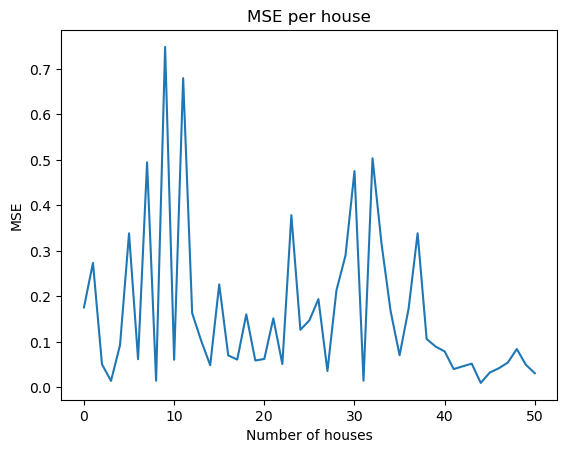

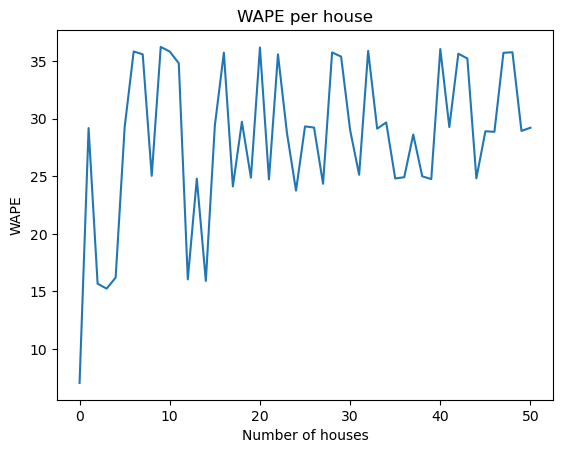

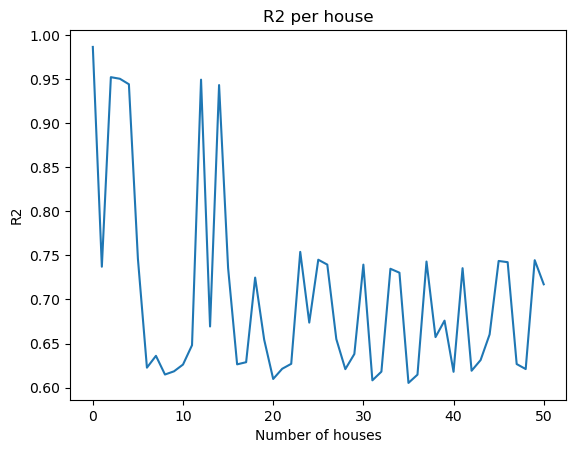

In [14]:
show_graphic_per_timestep(metrics_list_xgb, number_of_houses)

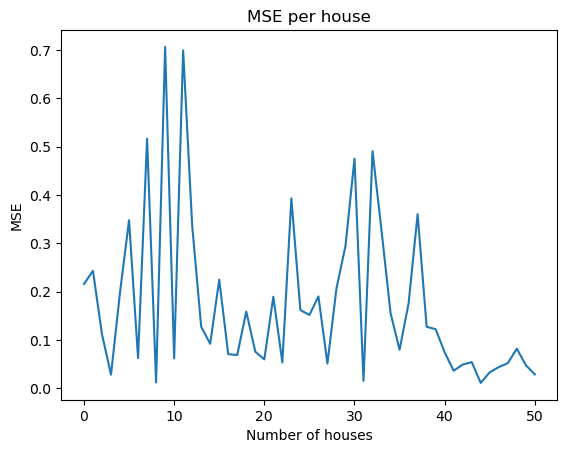

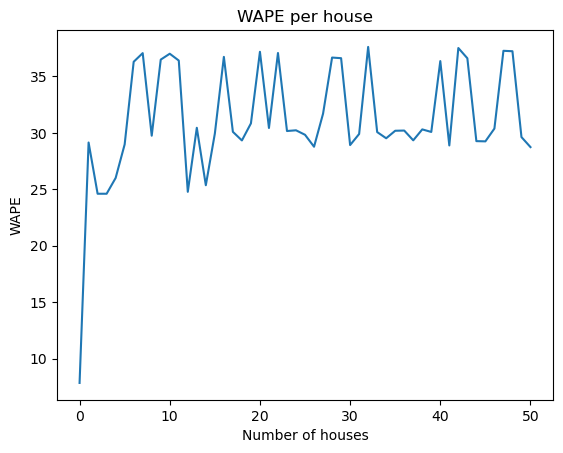

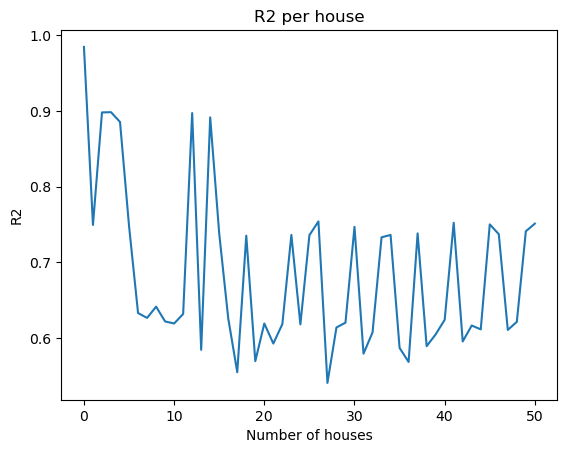

In [15]:
show_graphic_per_timestep(metrics_list_lr, number_of_houses)

### Total average

In [16]:
t_mse_lr, t_wape_lr, t_r2_lr = total_averaged_metrics_individual(metrics_list_lr)

Total Averaged MSE: 0.175
Total Averaged WAPE: 31.131
Total Averaged R2: 0.684


In [17]:
t_mse, t_wape, t_r2 = total_averaged_metrics_individual(metrics_list_xgb)

Total Averaged MSE: 0.163
Total Averaged WAPE: 28.335
Total Averaged R2: 0.704


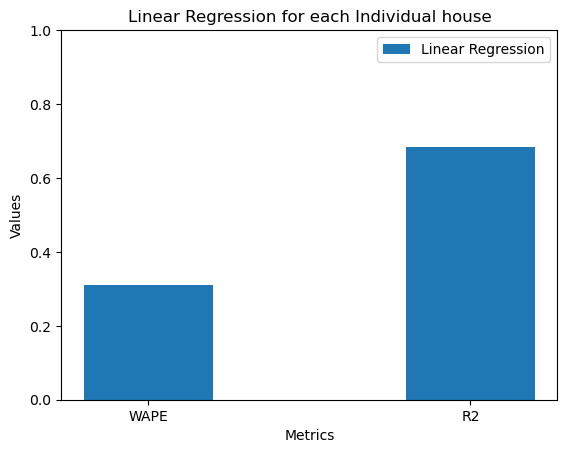

In [18]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis, (t_wape_lr / 100, t_r2_lr), 0.4, label = 'Linear Regression')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Linear Regression for each Individual house")
plt.legend()
plt.show()

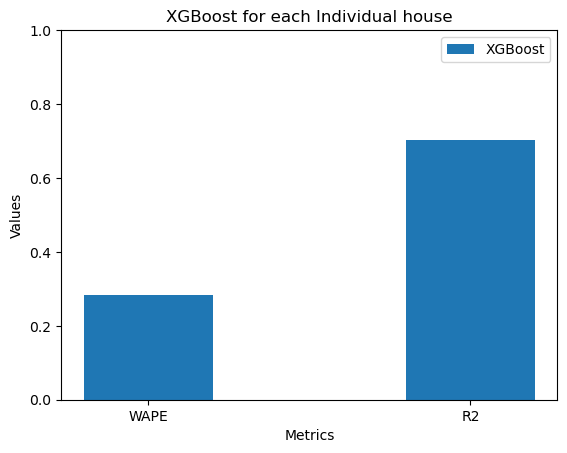

In [19]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis, (t_wape / 100, t_r2), 0.4, label = 'XGBoost')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("XGBoost for each Individual house")
plt.legend()
plt.show()